In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 
import keras_cv

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import umap


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = True
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-04-01 18:21:07.577492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-01 18:21:08.128704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/envs/umap/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda-11.2/lib64::/home/joel/anaconda3/lib/:/home/joel/anaconda3/envs/umap/lib/
2023-04-01 18:21:08.129172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such f

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [2]:
def augment(yx, crop=256, do_flips=True, do_rotate=True, do_scale=True):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 

    ch, cw = yx[0].shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.rand()*360*float(do_rotate),
                            1+float(do_scale)*(np.random.uniform(-0.2,0.2)))
    for i in range(len(yx)):
        yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    return yx
    
N_REPEAT_FRAME = 1

def sample_images(frame_nums):
    while True:
        try:
            
            var_anc = np.random.uniform(var_d,var_u)
            var_pos = np.random.uniform(var_d,var_u)
            var_neg = np.random.uniform(var_d,var_u)
            num_pos = np.random.choice(frame_nums)
            num_neg = np.random.choice(frame_nums)
            
            
            
            img_anc = [open_frame(num_pos,var_anc,CROP)[1]]
            img_pos = [open_frame(num_pos,var_pos,CROP)[1]]
            img_neg = [open_frame(num_neg,var_neg,CROP)[1]]
        except Exception as e:
            print(f'Exception {e} on file')
            continue
            
        
            
        for n in range(N_REPEAT_FRAME):
            
            a_anc =  augment(np.copy(img_anc),crop = CROP)[0]
            a_pos =  augment(np.copy(img_pos),crop = CROP)[0]
            a_neg =  augment(np.copy(img_neg),crop = CROP)[0]
            yield a_anc,a_pos,a_neg
            
def get_data_generator(sampler):
    def get_data():
        while True:
            yx = next(sampler)
            yx = np.expand_dims(yx,axis=-1)
            

            yield yx[0],yx[1],yx[2]
                    
    return get_data

test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

In [3]:
BATCH_SIZE = 50
train_var = False
var_d=0
var_u=60
pre = False
same = False

dg_train = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(train)),
    output_types=(tf.float32, tf.float32,tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1),(CROP, CROP, 1)) )

dg_val = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(test)),
    output_types=(tf.float32, tf.float32,tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1),(CROP, CROP, 1)) )

gen_batch_train = dg_train.batch(BATCH_SIZE)
gen_batch_val = dg_val.batch(BATCH_SIZE)

2023-04-01 18:21:11.400785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 18:21:11.401123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 18:21:11.406543: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 18:21:11.406765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 18:21:11.406948: I tensorflow/compiler/xla/stream_executo

In [4]:
anchor,pos,neg = next(gen_batch_val.as_numpy_iterator())

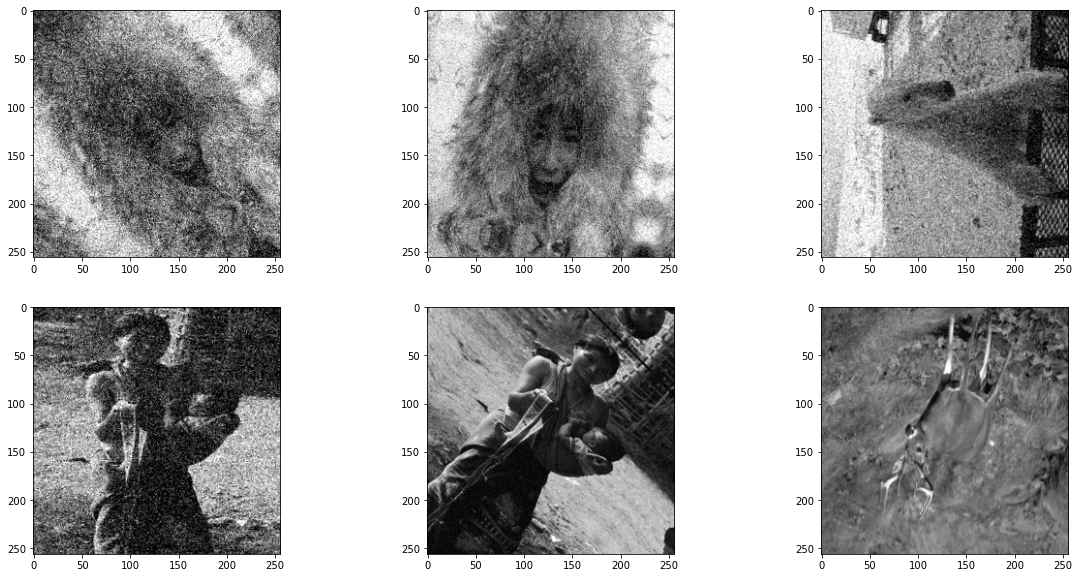

In [5]:
nrows,ncols = 2,3
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    _ = np.random.choice(len(anchor))
    axs[i,0].imshow(np.squeeze(anchor[_]),cmap='gray')
    axs[i,1].imshow(np.squeeze(pos[_]),cmap='gray')
    axs[i,2].imshow(np.squeeze(neg[_]),cmap='gray')
        
plt.show()

In [6]:
dim = 32*32
def classifier(inputs, option=1, num_classes=2,kernel_size=3,pool_size=3,CROP=256):
    
    inputs = inputs
    x = tf.keras.layers.Conv2D(32, kernel_size, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [16,32,64,128]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, kernel_size, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(pool_size, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(dim, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    return tf.keras.Model(inputs,x)

input_shape = image_size + (1,)
embedding = classifier(tf.keras.layers.Input(input_shape))

In [7]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = tf.keras.layers.Input(name="anchor", shape=input_shape)
positive_input = tf.keras.layers.Input(name="positive", shape=input_shape)
negative_input = tf.keras.layers.Input(name="negative", shape=input_shape)

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = tf.keras.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)


In [8]:
class SiameseModel(tf.keras.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [9]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.001))
siamese_model.load_weights(f"./checkpoints/autoencoder5")

callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/autoencoder5",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5),
                            tf.keras.callbacks.TerminateOnNaN()

                ]

In [91]:
siamese_model.fit(gen_batch_train,
        epochs=20,
        steps_per_epoch=50,
        validation_data=gen_batch_val,
        validation_steps=10,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.0642
Epoch 1: val_loss did not improve from 0.04968
50/50 [==============================] - 57s 1s/step - loss: 0.0642 - val_loss: 0.0596 - lr: 4.0000e-05
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.0714
Epoch 2: val_loss did not improve from 0.04968
50/50 [==============================] - 56s 1s/step - loss: 0.0714 - val_loss: 0.0870 - lr: 4.0000e-05
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.0491
Epoch 3: val_loss did not improve from 0.04968
50/50 [==============================] - 54s 1s/step - loss: 0.0491 - val_loss: 0.1238 - lr: 4.0000e-05
Epoch 4/20
50/50 [==============================] - ETA: 0s - loss: 0.0767
Epoch 4: val_loss did not improve from 0.04968
50/50 [==============================] - 51s 1s/step - loss: 0.0767 - val_loss: 0.1018 - lr: 4.0000e-05
Epoch 5/20
50/50 [==============================] - ETA: 0s - loss: 0.0659
Epoch 5: val_loss did

In [52]:
anchor_embedding, positive_embedding, negative_embedding = [],[],[]

for it in range(10):
    anchor,pos,neg = next(gen_batch_val.as_numpy_iterator())
    anchor_embedding.append(embedding(anchor))
    positive_embedding.append(embedding(pos))
    negative_embedding.append(embedding(neg))

    
anchor_embedding = np.concatenate(anchor_embedding)
positive_embedding = np.concatenate(positive_embedding)
negative_embedding = np.concatenate(negative_embedding)

2023-04-01 18:46:36.487911: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 916.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-01 18:46:36.487946: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 916.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-01 18:46:36.487952: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-01 18:46:36.487957: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator 

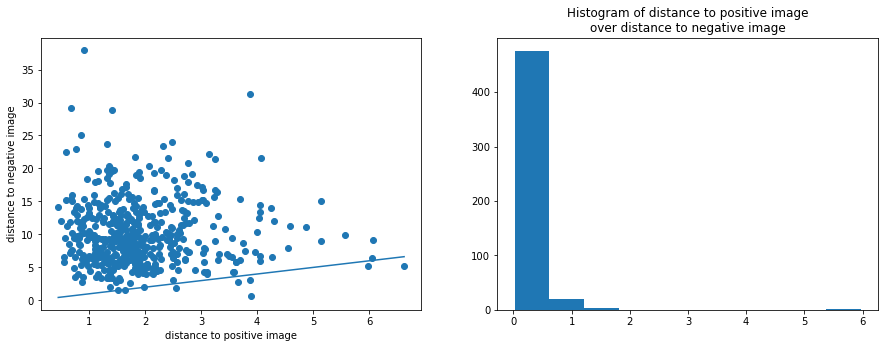

In [54]:
ap = np.linalg.norm(anchor_embedding-positive_embedding,axis=-1)
an = np.linalg.norm(anchor_embedding-negative_embedding,axis=-1)

plot = np.concatenate((ap,an))

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(ap,an)
plt.plot([np.amin(plot),np.amax(ap)],[np.amin(plot),np.amax(ap)])
plt.xlabel('distance to positive image')
plt.ylabel('distance to negative image')
plt.subplot(122)
plt.hist(ap/an)
plt.title('Histogram of distance to positive image\nover distance to negative image')
plt.show()

In [7]:
#embedding.save_weights('./checkpoints/embedding')
embedding.load_weights('./checkpoints/embedding')

# Visualizing embedding

In [8]:
reducer = umap.UMAP(n_neighbors=100,min_dist=0.1)

In [25]:
num_pos = np.random.choice(train)
anchor = open_frame(num_pos,0,CROP)[1]

noisy = []
rotated = []
num = 2000
size = 10
for i in np.linspace(0,60,num):
    pos = open_frame(num_pos,i,CROP)[1]
    noisy.append(np.copy(pos))
    
for i in np.linspace(0,360,num):
    pos = open_frame(num_pos,0,CROP)[0]
    ch, cw = pos.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),i,1)
    pos = cv2.warpAffine(pos,rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    rotated.append(pos)
    
    
noisy = np.array(noisy)
noisy = np.reshape(noisy,(num//size,size,CROP,CROP))

rotated = np.array(rotated)
rotated = np.reshape(rotated,(num//size,size,CROP,CROP))

embedded_noisy = np.concatenate([embedding(i) for i in noisy])
embedded_noisy_plot = reducer.fit_transform(embedded_noisy)

embedded_rotated = np.concatenate([embedding(i) for i in rotated])
embedded_rotated_plot = reducer.fit_transform(embedded_rotated)

embedded_noisy = np.concatenate([embedding(i) for i in noisy])
embedded_rotated = np.concatenate([embedding(i) for i in rotated])

embedded_pos = np.concatenate((embedded_noisy,embedded_rotated))
embedded_pos_plot = reducer.fit_transform(embedded_pos)

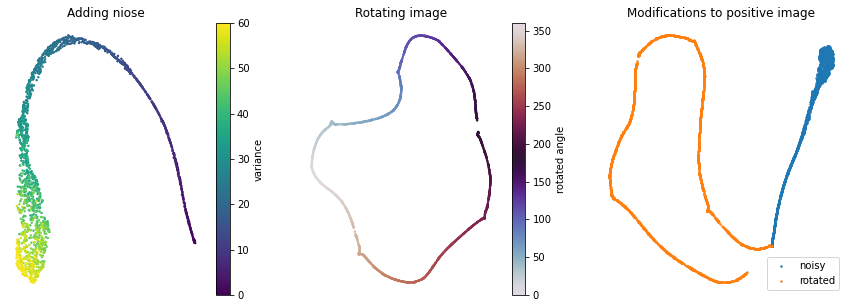

In [29]:
plt.figure(figsize=(15,5))

plt.subplot(131)
colors = cm.viridis(np.linspace(0,1,num))
x,y = embedded_noisy_plot.T
plt.scatter(x,y,s=2,color=colors)
sm = plt.cm.ScalarMappable(cmap=cm.viridis)
sm.set_clim(vmin=0, vmax=60)
plt.colorbar(sm,label='variance')
plt.title('Adding niose')
plt.axis('off')

plt.subplot(132)
colors = cm.twilight(np.linspace(0,1,num))
x,y = embedded_rotated_plot.T
plt.scatter(x,y,s=2,color=colors)

sm = plt.cm.ScalarMappable(cmap=cm.twilight)
sm.set_clim(vmin=0, vmax=360)
plt.colorbar(sm,label='rotated angle')
plt.title('Rotating image')
plt.axis('off')

plt.subplot(133)
x,y = embedded_pos_plot[:num].T
plt.scatter(x,y,s=2,label='noisy')
x,y = embedded_pos_plot[num:].T
plt.scatter(x,y,s=2,label='rotated')
plt.legend()
plt.title('Modifications to positive image')
plt.axis('off')


plt.show()

## Several images

In [50]:
en,er,ep = [],[],[]
images = 10

for im in tqdm(range(images)):

    num_pos = np.random.choice(train)
    anchor = open_frame(num_pos,0,CROP)[1]

    noisy = []
    rotated = []
    num = 500
    size = 10
    for i in np.linspace(0,60,num):
        pos = open_frame(num_pos,i,CROP)[1]
        noisy.append(np.copy(pos))

    for i in np.linspace(0,360,num):
        pos = open_frame(num_pos,0,CROP)[0]
        ch, cw = pos.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),i,1)
        pos = cv2.warpAffine(pos,rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        rotated.append(pos)


    noisy = np.array(noisy)
    noisy = np.reshape(noisy,(num//size,size,CROP,CROP))

    rotated = np.array(rotated)
    rotated = np.reshape(rotated,(num//size,size,CROP,CROP))

    embedded_noisy = np.concatenate([embedding(i) for i in noisy])
    #embedded_noisy_plot = reducer.fit_transform(embedded_noisy)

    embedded_rotated = np.concatenate([embedding(i) for i in rotated])
    #embedded_rotated_plot = reducer.fit_transform(embedded_rotated)

    embedded_noisy = np.concatenate([embedding(i) for i in noisy])
    embedded_rotated = np.concatenate([embedding(i) for i in rotated])

    embedded_pos = np.concatenate((embedded_noisy,embedded_rotated))
    #embedded_pos_plot = reducer.fit_transform(embedded_pos)
    
    en.append(np.copy(embedded_noisy))
    er.append(np.copy(embedded_rotated))
    ep.append(np.copy(embedded_pos))
    
    
en = np.concatenate(en)
er = np.concatenate(er)
ep = np.concatenate(ep)


embedded_noisy_plot = reducer.fit_transform(en)
embedded_rotated_plot = reducer.fit_transform(er)
embedded_pos_plot = reducer.fit_transform(ep)

100%|███████████████████████████████████████████| 10/10 [01:23<00:00,  8.37s/it]


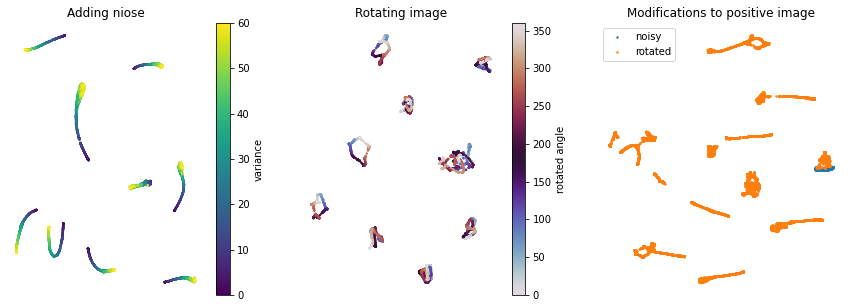

In [51]:
plt.figure(figsize=(15,5))

plt.subplot(131)
x,y = embedded_noisy_plot.T
colors = cm.viridis(np.linspace(0,1,num))
colors = np.concatenate(np.repeat([colors],images,axis=0))
plt.scatter(x,y,s=2,color=colors)
sm = plt.cm.ScalarMappable(cmap=cm.viridis)
sm.set_clim(vmin=0, vmax=60)
plt.colorbar(sm,label='variance')
plt.title('Adding niose')
plt.axis('off')

plt.subplot(132)
x,y = embedded_rotated_plot.T
colors = cm.twilight(np.linspace(0,1,num))
colors = np.concatenate(np.repeat([colors],images,axis=0))
plt.scatter(x,y,s=2,color=colors)

sm = plt.cm.ScalarMappable(cmap=cm.twilight)
sm.set_clim(vmin=0, vmax=360)
plt.colorbar(sm,label='rotated angle')
plt.title('Rotating image')
plt.axis('off')

plt.subplot(133)
x,y = embedded_pos_plot[:num].T
plt.scatter(x,y,s=2,label='noisy')
x,y = embedded_pos_plot[num:].T
plt.scatter(x,y,s=2,label='rotated')
plt.legend()
plt.title('Modifications to positive image')
plt.axis('off')


plt.show()